# Creating a new DDM fitting function

Here, we are going to go over how one would add a new fitting function. The function we will add is one which models a polydisperse collection of objects. We will be fitting the DDM matrix to the function:
$$D(q,\Delta t) = A(q) \left[ 1 - \exp \left( -\frac{\Delta t}{\tau(q)} \right) \left( 1 + \frac{\mu \tau^2}{2} \right) \right] + B(q)$$

So we will have four fitting parameters: $A$, $\tau$, $\mu$, and $B$. The relative polydispersity is given by $\mu \tau^2$.

## Importing the necessary modules

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np #numerical python used for working with arrays, mathematical operations
import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays
import sys
sys.path.append("../../PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm
import ISF_and_DDMmatrix_theoretical_models as models

## Creating the function

We will first create the function for this new model in the file `ISF_and_DDMmatrix_theoretical_models.py`. 

The first argument of this function will be the lagtime. The other arguments will be the four parameters in the model. 

In [2]:
####################################################################################
# THIS FUNCTION TO BE PLACED IN THE FILE `ISF_and_DDMmatrix_theoretical_models.py` #
####################################################################################

def dTheoryPolydisperse_DDM(lagtime,amplitude,tau,mu,bg):
    r"""Theoretical model for the  DDM matrix to account for polydisperisty
    
    Parameters
    ----------
    lagtime : array
        1D array of the lagtimes
    amplitude : float
        Amplitude, "A" in equation below
    tau : float
        The characteristic decay time
    mu : float
        To account for polydispersity
    bg : float
        Background term, "B" in equation below

    Returns
    -------
    ddm_matrix : array
        DDM matrix as shown in equation below

    Notes
    -----
    This model is used when polydispersity is present.

    .. math::
        D(q,\Delta t) = A(q) \left[ 1 - \exp \left( -\frac{\Delta t}{\tau(q)} \right) \left( 1 + \frac{\mu \tau^2}{2} \right) \right] + B(q)

    """
    relative_polydisp = mu * tau * tau
    isf = np.exp(-1 * (lagtime / tau)) * (1 + (relative_polydisp/2.0))
    ddm_matrix = amplitude * (1 - isf) + bg
    return ddm_matrix

## Creating the parameters dictionary

Next, we will create a dictionary in the file `fit_parameters_dictionaries.py`.

In [3]:
ddm_matrix_polydisperse = {}
ddm_matrix_polydisperse['parameter_info'] = [
        {'n': 0, 'value': 0, 'limits': [0,0], 'limited': [True,True],
         'fixed': False, 'parname': "Amplitude", 'error': 0, 'step':0},
        {'n': 1, 'value': 0, 'limits': [0,0], 'limited': [True,True],
         'fixed': False, 'parname': "Tau", 'error': 0, 'step':0},
        {'n': 2, 'value': 0, 'limits': [0,0], 'limited': [True,True],
         'fixed': False, 'parname': "Mu", 'error': 0, 'step':0},
        {'n': 3, 'value': 0, 'limits': [0,0], 'limited': [True,True],
         'fixed': False, 'parname': "Background", 'error': 0, 'step':0}]
ddm_matrix_polydisperse['model_function'] = models.dTheoryPolydisperse_DDM
ddm_matrix_polydisperse['data_to_use'] = 'DDM Matrix'

**Going over this dictionary**


* We first make an empty dictionary (we call it whatever we want):
```python
ddm_matrix_polydisperse = {}
```


* We then create a **list** of dictionaries using the key `parameter_info`. The number of elements in this list should be equal to the number of fitting parameters. For this new model we are implementing, we have $A$, $\tau$, $\mu$, and $B$. Each element in this list looks something like this:
```python
{'n': 0, 'value': 0, 'limits': [0,0], 'limited': [True,True],
         'fixed': False, 'parname': "Amplitude", 'error': 0, 'step':0}
```
Make sure to enter in the parameter name in for the key `parname`. Here, we have parameter names of `Amplitude`, `Tau`, `Mu`, and `Background`.
Also, the order of the paramters in `parameter_info` should match the order in which the arguments to the function `dTheoryPolydisperse_DDM` appear.


* We then provide the function which we made and placed in the file `ISF_and_DDMmatrix_theoretical_models.py` in the previous step:
```python
ddm_matrix_polydisperse['model_function'] = models.dTheoryPolydisperse_DDM
```


* Finally, we specify whether the data to be fit is the DDM matrix or the ISF:
```python
ddm_matrix_polydisperse['data_to_use'] = 'DDM Matrix'
```

## Adding dictionary to the fitting models

We next must add this dictionary that we created (`ddm_matrix_polydisperse`) to the dictionary `fitting_models` in the file `fit_parameters_dictionaries.py`.

Note that the key used for the dictionary `fitting_models` will be how we will refer to the model in the YAML file. Here, we are choosing to use the key 'DDM Matrix - Polydisperse'.

In [4]:
fitting_models = {}
fitting_models['DDM Matrix - Polydisperse'] = ddm_matrix_polydisperse

## Trying out the new model!

In [13]:
import yaml
ddm_analysis_parameters_str = """
DataDirectory: 'C:/Users/rmcgorty/Documents/GitHub/DDM-at-USD/ExampleData/'
FileName: 'images_nobin_40x_128x128_8bit.tif'
Metadata:
  pixel_size: 0.242 # size of pixel in um
  frame_rate: 41.7 #frames per second
Analysis_parameters:
  number_lag_times: 40
  last_lag_time: 600
  binning: no 
  overlap_method: 1
Fitting_parameters:
  model: 'DDM Matrix - Polydisperse' 
  Tau: [1.0, 0.001, 10]
  Mu: [0.4, 0.001, 100]
  StretchingExp: [1.0, 0.5, 1.1]
  Amplitude: [1e2, 1, 1e6]
  Background: [2.5e4, 0, 1e7]
  Good_q_range: [5, 20]
  Auto_update_good_q_range: True
"""
parameters_as_dictionary = yaml.safe_load(ddm_analysis_parameters_str)

In [8]:
ddm_calc = ddm.DDM_Analysis(parameters_as_dictionary)

Provided metadata: {'pixel_size': 0.242, 'frame_rate': 41.7}
Image shape: 3000-by-128-by-128
Number of frames to use for analysis: 3000
Maximum lag time (in frames): 600
Number of lag times to compute DDM matrix: 40
Using the full frame, dimensions: 128-by-128.


The file C:/Users/rmcgorty/Documents/GitHub/DDM-at-USD/ExampleData/images_nobin_40x_128x128_8bit_ddmmatrix.nc already exists. So perhaps the DDM matrix was calculated already?
Do you still want to calculate the DDM matrix? (y/n): y


2022-02-15 11:44:34,640 - DDM Calculations - Running dt = 1...
2022-02-15 11:44:41,652 - DDM Calculations - Running dt = 5...
2022-02-15 11:44:45,105 - DDM Calculations - Running dt = 9...
2022-02-15 11:44:48,323 - DDM Calculations - Running dt = 16...
2022-02-15 11:44:52,230 - DDM Calculations - Running dt = 27...
2022-02-15 11:44:55,881 - DDM Calculations - Running dt = 47...
2022-02-15 11:44:59,466 - DDM Calculations - Running dt = 81...
2022-02-15 11:45:04,809 - DDM Calculations - Running dt = 138...
2022-02-15 11:45:07,986 - DDM Calculations - Running dt = 236...
2022-02-15 11:45:11,031 - DDM Calculations - Running dt = 402...


DDM matrix took 39.641406536102295 seconds to compute.
 Background estimate ± std is 211.17 ± 1.49


<xarray.Dataset>
Dimensions:           (lagtime: 40, q_y: 128, q_x: 128, q: 64, y: 128, x: 128, frames: 40)
Coordinates:
  * lagtime           (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
    framelag          (frames) int32 1 2 3 4 5 6 7 ... 308 352 402 459 525 599
  * q_y               (q_y) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q_x               (q_x) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 175.0 193.1 ... 172.1 186.3
    ddm_matrix        (lagtime, q) float64 0.0 295.8 314.5 ... 206.3 208.3 207.5
    first_image       (y, x) float64 128.0 149.0 173.0 ... 175.0 229.0 215.0
    avg_image_ft      (q) float64 0.0 1.293e+05 5.225e+03 ... 105.3 104.7 105.3
    num_pairs_per_dt  (lagtime) int32 300 300 300 300 300 ... 289 283 275 267
    B                 float64 211.2
    B_std             float64 1.491
    Amplitude         (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    ISF               (lagtime, q) float64 0.0 0.9997 0.9899 ... -0.6879 -6.08
Attributes: (12/16)
    units:             Intensity
    lagtime:           sec
    q:                 μm$^{-1}$
    x:                 pixels
    y:                 pixels
    info:              ddm_matrix is the averages of FFT difference images, r...
    ...                ...
    pixel_size:        0.242
    frame_rate:        41.7
    number_lag_times:  40
    last_lag_time:     600
    binning:           no
    overlap_method:    yes

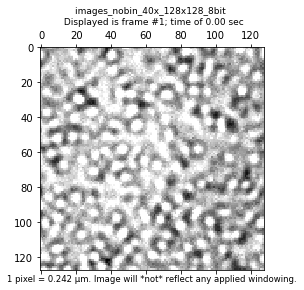

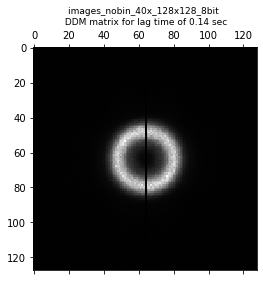

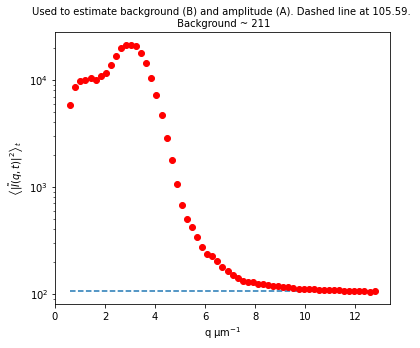

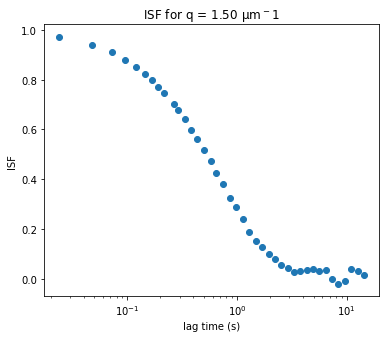

In [9]:
ddm_calc.calculate_DDM_matrix()

### Initiazing DDM_Fit class and fitting our data to a model


In [16]:
ddm_fit = ddm.DDM_Fit(parameters_as_dictionary)

,Initial guess,Minimum,Maximum
Amplitude,100.0,1.000,1000000.0
Tau,1.0,0.001,10.0
Mu,0.4,0.001,100.0
Background,25000.0,0.000,10000000.0


Loading file C:/Users/rmcgorty/Documents/GitHub/DDM-at-USD/ExampleData/images_nobin_40x_128x128_8bit_ddmmatrix.nc ...


In [17]:
fit01 = ddm_fit.fit(name_fit = 'fit01')

Fit is saved in fittings dictionary with key 'fit01'.


,q,Amplitude,Tau,Mu,Background
0,0.000000,1.000000,10.000000,0.003189,0.000000
1,0.202840,15.918614,4.263357,18.534856,3400.434926
2,0.405681,30.332247,3.518539,25.931651,5629.668970
3,0.608521,57.581148,2.961575,33.770350,9265.281048
4,0.811362,190.065873,2.145075,32.532448,14967.489051
5,1.014202,473.955467,1.351004,40.002862,17802.347026
6,1.217043,957.582514,0.975331,39.887403,18574.906136
7,1.419883,1549.598673,0.744532,42.757955,18671.705002
8,1.622723,2291.933349,0.550475,47.784090,16934.983376
9,1.825564,2975.005723,0.467657,56.028242,18384.154790


### Inspecting the outcome of the fit

<xarray.Dataset>
Dimensions:          (parameter: 4, q: 64, lagtime: 40)
Coordinates:
  * parameter        (parameter) <U10 'Amplitude' 'Tau' 'Mu' 'Background'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 1.0 15.92 30.33 ... 196.7 194.7
    theory           (lagtime, q) float64 -0.1567 734.1 794.1 ... 206.7 206.4
    isf_data         (lagtime, q) float64 0.0 0.9997 0.9899 ... -0.6879 -6.08
    ddm_matrix_data  (lagtime, q) float64 0.0 295.8 314.5 ... 206.3 208.3 207.5
    A                (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    B                float64 211.2
Attributes: (12/18)
    model:                          DDM Matrix - Polydisperse
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.7148238989957726
    tau_vs_q_slope:                 [-1.784258]
    msd_alpha:                      [1.12091413]
    ...                             ...
    DataDirectory:                  C:/Users/rmcgorty/Documents/GitHub/DDM-at...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7
    BackgroundMethod:               0
    OverlapMethod:                  1

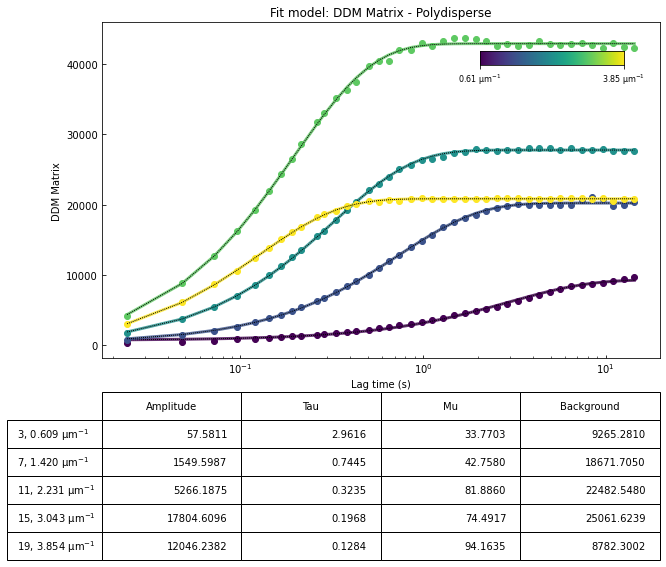

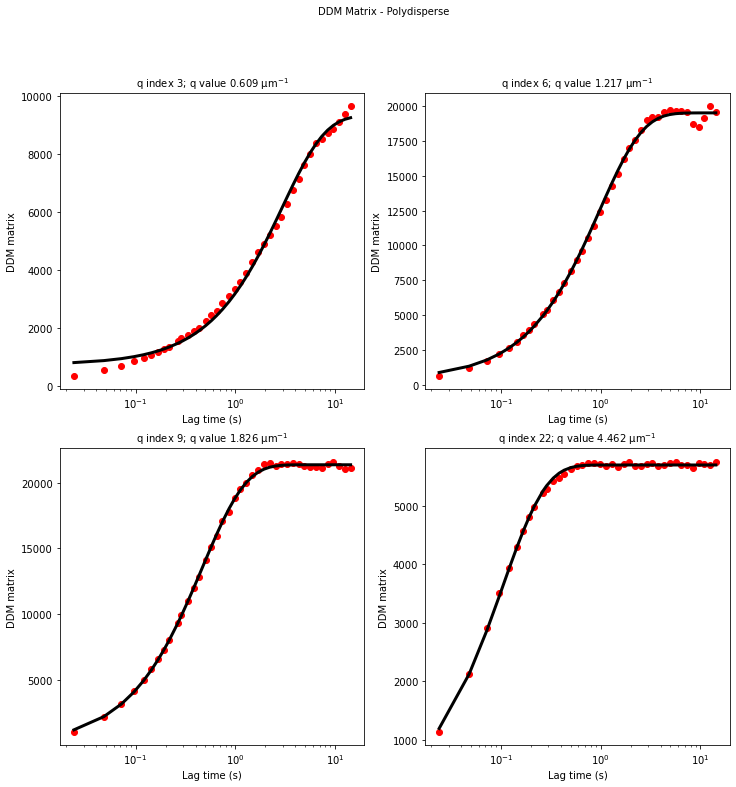

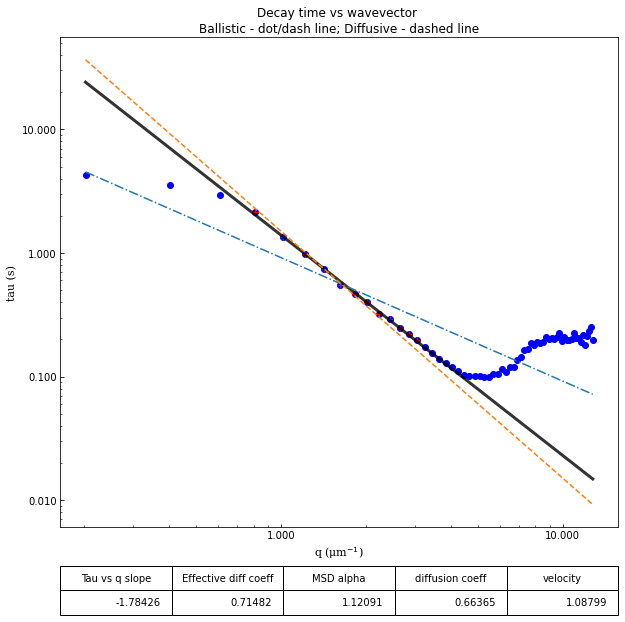

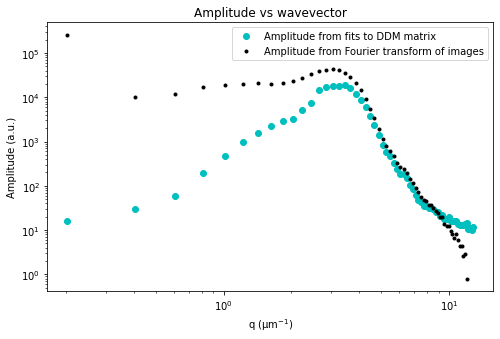

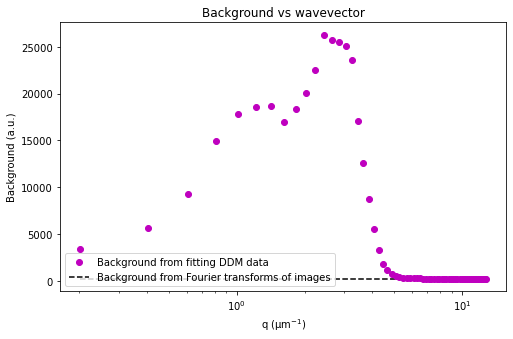

In [18]:
ddm.fit_report(fit01, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=True, show=True)

Text(0, 0.5, '$\\mu \\tau^2$')

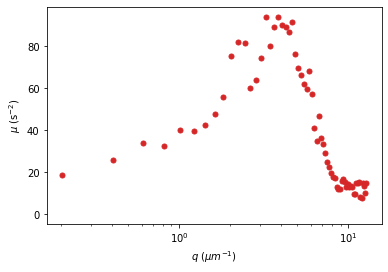

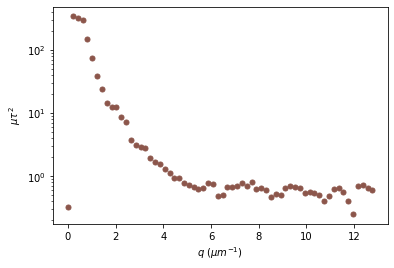

In [32]:
########################################
# Plotting mu vs q                     #
########################################

plt.figure()
plt.semilogx(fit01.q, fit01.parameters.loc['Mu'], 'o', color='tab:red', ms=5)
plt.xlabel("$q$ ($\mu m^{-1}$)")
plt.ylabel("$\mu$ (s$^{-2}$)")


########################################
# Plotting mu vs q                     #
########################################

plt.figure()
plt.semilogy(fit01.q, fit01.parameters.loc['Mu'] * fit01.parameters.loc['Tau']**2, 'o', color='tab:brown', ms=5)
plt.xlabel("$q$ ($\mu m^{-1}$)")
plt.ylabel("$\mu \\tau^2$")